### Packages Import

In [127]:
import pandas as pd
import numpy as np
from time import time
import visuals as vs

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone # functionality for cloning a model

import matplotlib 
import matplotlib.pyplot as plt

%matplotlib inline

### Loading and Exploring Data

In [2]:
df = pd.read_csv('census.csv')

In [10]:
df.head(2)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K


In [15]:
print('The dataset has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

The dataset has 45222 rows and 14 columns.


In [16]:
# Statistics on each variable (both numeric and categorical) 

df.describe(include='all')

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,45222.000000,45222,45222,45222.000000,45222,45222,45222,45222,45222,45222.000000,45222.000000,45222.000000,45222,45222
unique,NaN,7,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33307,14783,NaN,21055,6020,18666,38903,30527,NaN,NaN,NaN,41292,34014
mean,38.547941,NaN,NaN,10.118460,NaN,NaN,NaN,NaN,NaN,1101.430344,88.595418,40.938017,NaN,NaN
std,13.217870,NaN,NaN,2.552881,NaN,NaN,NaN,NaN,NaN,7506.430084,404.956092,12.007508,NaN,NaN
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [17]:
df.income.value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [24]:
print('The number of people whose income is more than 50K is {}.'.format(len(df[df.income == '>50K'])))
print('The number of people whose income is less than or equal to 50K is {}.'.format(len(df[df.income == '<=50K'])))

The number of people whose income is more than 50K is 11208.
The number of people whose income is less than or equal to 50K is 34014.


In [32]:
total = len(df)
more_than_50 = len(df[df.income == '>50K'])

print('The proportion of people making more than 50K is: {}%'.format(np.round((more_than_50/total)*100., 2)))

The proportion of people making more than 50K is: 24.78%


### Preparing the Data

In [6]:
# Checking null values within each variable

df.isnull().sum()

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

* #### Separating input variables from target

In [33]:
target = df.income
raw_features = df.drop('income', axis=1)

* #### Transforming Skewed Continues Features 

/Users/jessicagarre/Desktop/Projects/CharityML/visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


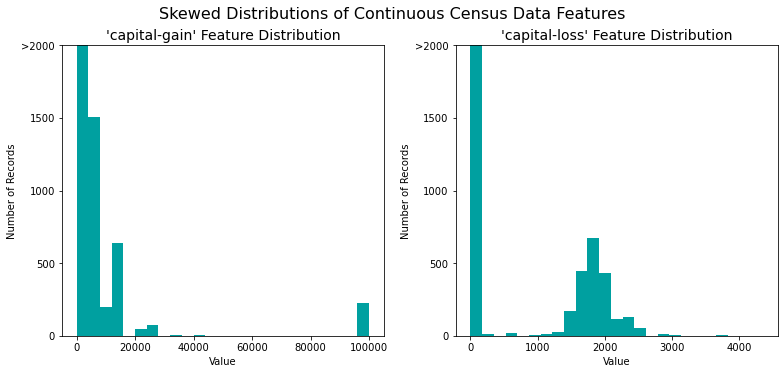

In [35]:
# Visualize skewed continuous features of original data

vs.distribution(df)

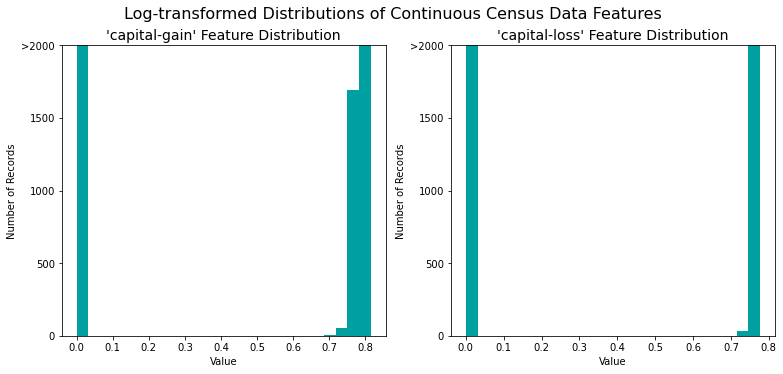

In [42]:
# Log-transform the skewed features

skewed = ['capital-gain', 'capital-loss']

features         = raw_features
features[skewed] = features[skewed].apply(lambda x: np.log(x + 1)) 

# Note: The logarithm of 0 is undefined, so we needed to translate the values 
# by a small amount above 0 to apply the the logarithm successfully

# Visualize the new log distribution
vs.distribution(features, transformed=True)

* #### Normalizing Numerical Features

In [43]:
num_features = features.select_dtypes(include=np.number).columns.tolist()

In [44]:
# Initialize scaler
scaler = MinMaxScaler()

In [45]:
# Apply scaler to the features
features[num_features] = scaler.fit_transform(features[num_features])

features.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.93922,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


* #### Categorical Data - One-Hot Encoding

In [47]:
cat_features = features.select_dtypes(include='O').columns.tolist()

In [49]:
dummies = pd.get_dummies(df[cat_features])
dummies.head()

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_level_ 10th,education_level_ 11th,education_level_ 12th,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Drop original names from categorical variables
features.drop(cat_features, axis=1, inplace=True)

# Concat dummies within features
features = pd.concat([features, dummies], axis=1)
features.head(2)

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.8,0.93922,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.8,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


* #### Categorical Data - Target

In [52]:
target = target.apply(lambda x: 0 if x == '<=50K' else 1)

#### Shuffle and Split the Data

In [59]:
# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [60]:
# Show the results of the split
print('Training set has {} samples.'.format(X_train.shape[0]))
print('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


### Model Implementation

In [128]:
def train_predict(model, sample_size, X_train, y_train, X_test, y_test):
    
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: target training set
       - X_test: features testing set
       - y_test: target testing set
    '''
    
    results = {}
    
    # Fit the model within the training data, slicing it by 'sample_size'. Obtain training time
    start = time()
    model = model.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end - start
    
    
    # Predict target on the train and test sets and obtain total prediction time
    start = time()
    predictions_train = model.predict(X_train[:300]) # For training, we just predict the first 300 samples
    predictions_test = model.predict(X_test)
    end = time()
    
    results['pred_time'] = end - start
    
    # Calculate accuracy and F-score on train set
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    
    # Calculate accuracy and F-score on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    
    
    print('{} trained on {} samples.'.format(model.__class__.__name__, sample_size))
    print('Accuracy - train: {:.2f}, test: {:.2f}'.format(results['acc_train'], results['acc_test']))
    print('F-score  - train: {:.2f}, test: {:.2f}'.format(results['f_train'], results['f_test']))
    print()
        
    return results

In [129]:
# Initialize models whose performance we are going to test
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 42)
clf_C = RandomForestClassifier(random_state = 42)
clf_D = AdaBoostClassifier(random_state = 42)
clf_E = GradientBoostingClassifier(random_state = 42)

models = [clf_A, clf_B, clf_C, clf_D, clf_E]

We will perform the training and testing of the model for different sizes of the data, so that we can see the impact it has on the results.

In [130]:
# Number of samples for 1%, 10%, and 100% of the training data
train_size = X_train.shape[0]

samples_100 = train_size
samples_10  = int(0.1 * train_size)
samples_1   = int(0.01 * train_size)

samples = [samples_1, samples_10, samples_100]

In [131]:
# Collect results on the models

results = {}

for clf in models:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    
    for i, sample in enumerate(samples):
        results[clf_name][i] = train_predict(clf, sample, X_train, y_train, X_test, y_test)

LogisticRegression trained on 361 samples.
Accuracy - train: 0.87, test: 0.82
F-score  - train: 0.76, test: 0.64

LogisticRegression trained on 3617 samples.
Accuracy - train: 0.85, test: 0.84
F-score  - train: 0.71, test: 0.67



/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression trained on 36177 samples.
Accuracy - train: 0.84, test: 0.84
F-score  - train: 0.69, test: 0.68

SVC trained on 361 samples.
Accuracy - train: 0.86, test: 0.82
F-score  - train: 0.75, test: 0.63

SVC trained on 3617 samples.
Accuracy - train: 0.86, test: 0.83
F-score  - train: 0.74, test: 0.66

SVC trained on 36177 samples.
Accuracy - train: 0.85, test: 0.84
F-score  - train: 0.72, test: 0.68

RandomForestClassifier trained on 361 samples.
Accuracy - train: 1.00, test: 0.82
F-score  - train: 1.00, test: 0.62

RandomForestClassifier trained on 3617 samples.
Accuracy - train: 1.00, test: 0.84
F-score  - train: 1.00, test: 0.67

RandomForestClassifier trained on 36177 samples.
Accuracy - train: 0.98, test: 0.84
F-score  - train: 0.97, test: 0.68

AdaBoostClassifier trained on 361 samples.
Accuracy - train: 0.89, test: 0.82
F-score  - train: 0.80, test: 0.63

AdaBoostClassifier trained on 3617 samples.
Accuracy - train: 0.84, test: 0.85
F-score  - train: 0.68, test: 0.70

### Model Tunning - Grid Search 

We will choose GradientBoostingClassifier as it provides the best combination of performance in terms of results and overfitting. 

In [147]:
# Initialize the classifier
clf = RandomForestClassifier(random_state = 42)

In [152]:
# Create parameters we want to tune
parameters = {'n_estimators'     : [100, 1000, 2000], 
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf' : [1, 2, 4]}

In [153]:
# Make F-score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

In [154]:
# Create grid search object
grid = GridSearchCV(clf,
                    parameters,
                    scorer)

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [155]:
print('Starting fitting training data.')

# Fit it to the training data
start = time()
grid_fit = grid.fit(X_train, y_train)
end = time()

print('Finished. Fitting time: {}'.format(end - start))

Starting fitting training data.
Finished. Fitting time: 45201.938997745514


In [156]:
# Obtain best estimator
best_clf = grid_fit.best_estimator_
best_clf

RandomForestClassifier(min_samples_leaf=2, n_estimators=2000, random_state=42)

In [157]:
# Make predictions using both, the unoptimazed model and the best classifier chosen
unopt_pred = (clf.fit(X_train, y_train)).predict(X_test)
best_pred  = best_clf.predict(X_test)

In [161]:
# Report the before-and-afterscores
print('Unoptimized model:')
print('Accuracy score on testing data: {:.3f}'.format(accuracy_score(y_test, unopt_pred)))
print('F-score on testing data: {:.3f}'.format(fbeta_score(y_test, unopt_pred, beta = 0.5)))
print('\nOptimized Model')
print('Final accuracy score on the testing data: {:.3f} (training: {:.2f})'.format(accuracy_score(y_test, best_pred), accuracy_score(y_train, best_clf.predict(X_train))))
print('Final F-score on the testing data: {:.3f} (training: {:.2f})'.format(fbeta_score(y_test, best_pred, beta = 0.5), fbeta_score(y_train, best_clf.predict(X_train), beta = 0.5)))

Unoptimized model:
Accuracy score on testing data: 0.842
F-score on testing data: 0.681

Optimized Model
Final accuracy score on the testing data: 0.861 (training: 0.89)
Final F-score on the testing data: 0.732 (training: 0.81)


Even when tunning the parameters the model does not perform too well, however we can see that we were able to remove the overfitting we observed before. 

Can we assume that maybe we don't have enough (or the right) information for a model to work well? Maybe the data is too skweded? We saw it at the beginning, as the values of the target were distributed 25-75%, which is not ideal.

#### Features importance

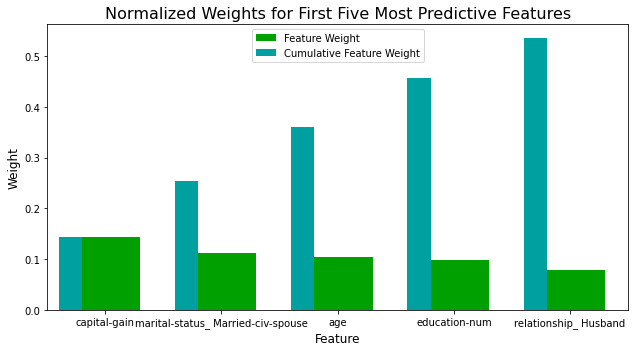

In [159]:
importances = best_clf.feature_importances_

# Plot feature importances
vs.feature_plot(importances, X_train, y_train)

Let's see how the mode performs if we just use these 5 features for training. 

In [160]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_pred = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print('Final Model trained on full data')
print('Accuracy on testing data: {:.3f}'.format(accuracy_score(y_test, best_pred)))
print('F-score on testing data: {:.3f}'.format(fbeta_score(y_test, best_pred, beta = 0.5)))
print('\nFinal Model trained on reduced data')
print('Accuracy on testing data: {:.3f}'.format(accuracy_score(y_test, reduced_pred)))
print('F-score on testing data: {:.3f}'.format(fbeta_score(y_test, reduced_pred, beta = 0.5)))

Final Model trained on full data
Accuracy on testing data: 0.861
F-score on testing data: 0.732

Final Model trained on reduced data
Accuracy on testing data: 0.843
F-score on testing data: 0.688


The reduction of performance that is produced when reducing the data is quite low, which means that these five features capture most of the information for the model.